# Richardson Lucy Algorithm
Even knowing convolution kernel isn't enough to de-blur an image. This is because any noise present in the image is amplified during de-convolution and adds significant visual disturbances. This section looks at the Richardson Lucy algorithm which is an iterative method for recovering convoluted images which are also corrupted by noise.

## Aims
- Understand the Richardson Lucy algorithm
- Implement the Richardson Lucy algorithm and deblur images
- Compare the Richardson Lucy algorithm with just using the Fourier transform to deconvolve a noisy image.

## Theory
The matrices $f$, $f'$ and $k$ describe the proportion of light in: the true image, the observed image and the convolution kernel respectively, and are related by either $f'_i =\sum_j k_{i,j}f_j$ or $f' = f * k$. When the letters are unscripted (e.g. $f$) that means they are referring to the whole array. When they are scripted (e.g. $f_{i}$) then they are referring to the value in the $i$ th location. 

The Richardson Lucy algorithm is an iterative process which predicts predicts the true image accounting for noise:
$$\hat{f}_j^{t+1} = \hat{f}_j^{t}\sum_i \frac{f'^{t}_i}{\hat{f'}^{t}_i}k_{i,j} \text{  [1]}$$
- Where $\hat{f}_j^{t+1}$ is the $t+1$ th estimated value of $f_j$. 
- $\hat{f'}_i$ is the predicted light intensity in the observed image given as $\hat{f'}_i = \sum_j k_{i,j}\hat{f}_j$.   
- $\frac{f'^t_i}{\hat{f}^{t}_i}$ is the correcting factor. It determines the difference between the measured light intensity and the prediction of the light intensity from the previous estimate. 
- If $p_{i,j}$ is normalized ($\sum_j p_{i,j} = 1$) 
- The richardson lucy algorithm often converges as the process is self correcting [1].

Using convolution the algorithm can be written for the 2D case:
$$\hat{p}^{t+1} = \hat{p}^{t} \cdot \left(\frac{d^t}{\hat{d}^{t}}*q^* \right)$$
- Where $\hat{p}^{t}$ is the $t$ th estimated value of $p$.
- Where $q^*$ is the mirrored convolution kernel.
- $\hat{d}$ is the predicted light intensity in the observed image given as: $\hat{d}^{t} = \hat{p}^{t} * q$.
- $\frac{d^t_i}{\hat{d}^{t}_i}$ is the correcting factor. 
## Basic 1D implementat

## Python implementation

In [1]:
from torchvision import transforms
import torch
from PIL import Image
import matplotlib.pyplot as plt
from ImageDebluring import *

ModuleNotFoundError: No module named 'torchvision'

## Degrading the image

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

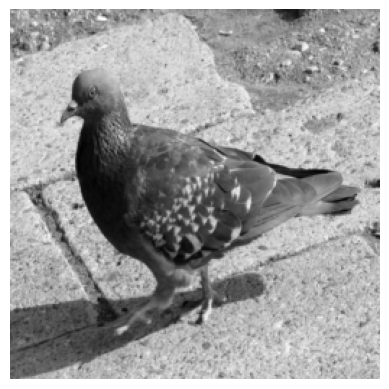

In [2]:
# Load images
folder = 'Images/'
device = 'cpu'
image = 'pigeon.jpeg'

image_path = folder + image  # Replace with your image path
image = Image.open(image_path)
transform = transforms.Compose([
        transforms.Grayscale(),  # Convert to grayscale
        transforms.Resize((256, 256)), # Resize to 256x256 to speed up processing
        transforms.ToTensor()  
    ])
img_tensor = transform(image).squeeze()  # Remove channel dimension

# Display the image
plt.imshow(img_tensor, cmap='gray')
plt.axis('off')



kernel shape: torch.Size([11, 11])


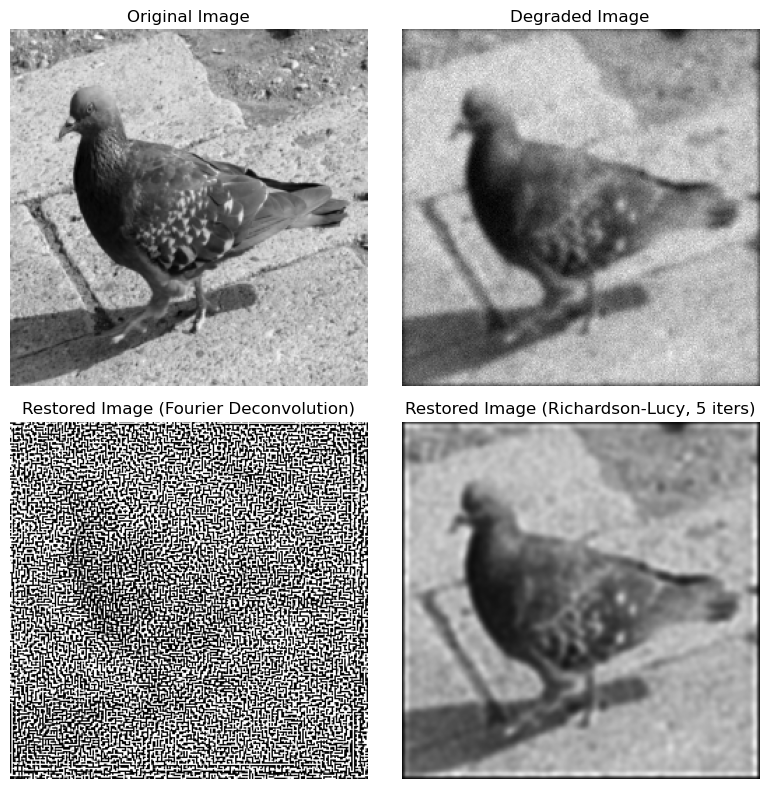

In [3]:
from scipy.signal import convolve2d as conv2

from skimage import color, data, restoration


iters_rl = 5
kernel = gaussian_normalised_kernel(size=11, sigma=2.0)
blury_image = convolution(img_tensor, kernel)
degraded_image = add_poisson_noise(blury_image, scale_factor=500)

restored_image_ft = deconvolution(degraded_image, kernel)
restored_image_rl30 = richardson_lucy(degraded_image, kernel, num_iters=iters_rl)
restored_image_rlski = restoration.richardson_lucy(degraded_image.numpy(), kernel.numpy().squeeze(), num_iter=iters_rl)


# Display the results
fig, axs = plt.subplots(2, 2, figsize=(8,8))
axs[0,0].imshow(img_tensor, cmap='gray')
axs[0,0].set_title('Original Image')
axs[0,0].axis('off')
axs[0,1].imshow(degraded_image, cmap='gray')
axs[0,1].set_title('Degraded Image')
axs[0,1].axis('off')
axs[1,0].imshow(restored_image_ft, cmap='gray')
axs[1,0].set_title('Restored Image (Fourier Deconvolution)')
axs[1,0].axis('off')
axs[1,1].imshow(restored_image_rl30, cmap='gray')
axs[1,1].set_title(f'Restored Image (Richardson-Lucy, {iters_rl} iters)')
axs[1,1].axis('off')

fig.tight_layout()

## Discussion

- De-convolution by fourier transform doesn't work. The image is unrecognisable and the noise seems to have been amplified by the de-convolution.
- The Richardson Lucy algorithm removes most of the noise and also helps to de-blur the image. The contrast on the new image isn't as clear as the original image but is much better than the observed image.
- The skimage implementation of the RLA has the same effect as the one programmed above with no noticeable difference for 5 iterations. However for a larger number of iterations the above implementation causes the image to become very dark. Prehaps this is due to the normalisation factor $\frac{f'^t_i}{\hat{f}^{t}_i}$ always being less than 1. It is unclear why this is happening. 
- Although the RLA seems to work for the complex image (pigeon) the darkening after a larger number of iterations is concerning. Each time the convolution kernel is applied over the image it makes the image smaller, therefore padding is used to keep the image the same size. The padding involves adding zeros to the edge of the image where the convolution cannot be applied. This means that the edge of the image is darker than the rest of the image. The RLA is an iterative process and therefore this darkening effect is amplified each time the convolution kernel is applied, therefore the image becomes darker after many iterations especially when the kernel size and standard deviation are large.